# Traitement de texte et NLP

In [1]:
# on importe les differentes librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
import networkx as nx
import nltk

# on importe les different module pour le traitement de texte
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# on importe notre bdd
avis_norm = pd.read_csv("BDD/avis_norm.csv")

In [2]:
avis_norm.head(1)

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,author,date_published,title_review,note,title,url,comment,comment_propre,nombre_mots_comment_propre
0,0,0,0,0,0,Monsieur Guillaume,2021-01,Voyages sur les ailes des papillons,0.8,Mariposas,https://www.trictrac.net/jeu-de-societe/maripo...,"Lorsque le jeu est jeu, bon, réflexif, joli po...",lorsque est bon réflexif joli est sensible sty...,59


In [3]:
# Charger le modèle de langue française
nlp = spacy.load('fr_core_news_sm')

# Fonction adaptée pour traiter chaque commentaire individuellement
def filtrer_commentaire(commentaire):
    doc = nlp(commentaire)
    pos_exclues = ['DET', 'CONJ', 'PRON', 'ADP', 'CCONJ']
    mots_exclus = ['jeu', 'jeux']
    mots_filtres = [token.text for token in doc if token.pos_ not in pos_exclues and token.lemma_.lower() not in mots_exclus]
    return ' '.join(mots_filtres)
# S'assurer que tous les commentaires sont des chaînes de caractères
avis_norm['comment'] = avis_norm['comment'].astype(str)

In [4]:
# Obtenir des statistiques descriptives pour les longueurs de commentaires
statistiques_longueurs = avis_norm['nombre_mots_comment_propre'].describe()

# Afficher les statistiques
print(statistiques_longueurs)

count    125299.000000
mean         52.442693
std          64.488792
min           0.000000
25%          13.000000
50%          36.000000
75%          70.000000
max        1833.000000
Name: nombre_mots_comment_propre, dtype: float64


In [5]:
# Filtrage des commentaires longs en utilisant un seuil spécifique basé sur le nombre de mots
seuil_nombre_mots = 70 # Considéré comme long s'il contient plus de 70 mots 25% des commentaires plus long
commentaires_longs = avis_norm[avis_norm['nombre_mots_comment_propre'] > seuil_nombre_mots]['comment_propre'].tolist()

# nombre de commentaires longs
print(f"Nombre de commentaires longs : {len(commentaires_longs)}")


Nombre de commentaires longs : 30753


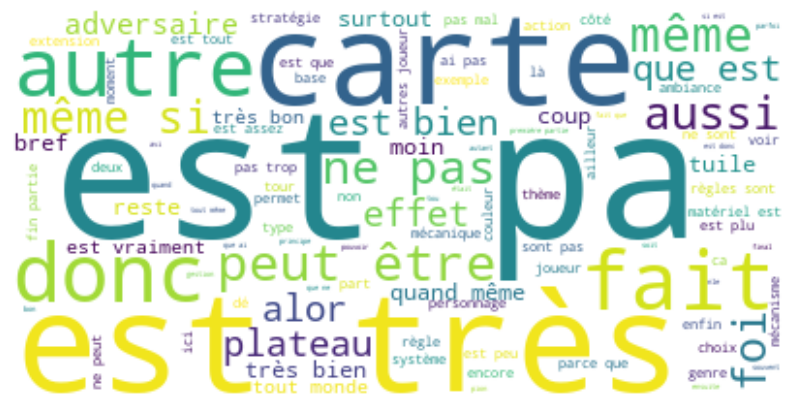

In [6]:
# Joindre tous les commentaires longs en une seule chaîne de texte
texte_long = " ".join(commentaires_longs)

# Créer un objet WordCloud
nuage_de_mots = WordCloud(background_color='white', max_words=100, contour_color='steelblue')

# Générer le nuage de mots
nuage_de_mots.generate(texte_long)

# Afficher le nuage de mots avec matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(nuage_de_mots, interpolation='bilinear')
plt.axis('off')  # Ne pas afficher les axes pour une meilleure visualisation
plt.show()

In [7]:
# Calculer les 100 mots les plus fréquents dans la chaîne de texte longue
mots_frequents = Counter(texte_long.split()).most_common(100)
for f in mots_frequents:
    print(f)

('est', 151621)
('pas', 84012)
('que', 68165)
('plus', 56458)
('ne', 47239)
('bien', 39507)
('très', 36147)
('sont', 31200)
('cartes', 30212)
('même', 27789)
('tout', 27554)
('si', 27131)
('peu', 26022)
('partie', 24925)
('joueurs', 24736)
('peut', 23760)
('fait', 23669)
('qu', 21988)
('ai', 21282)
('faire', 20457)
('être', 19492)
('bon', 18430)
('parties', 17508)
('jouer', 16502)
('donc', 15575)
('faut', 14491)
('autres', 14216)
('trop', 14086)
('règles', 13590)
('aussi', 13022)
('vraiment', 12595)
('assez', 12282)
('quand', 12139)
('moins', 11706)
('deux', 11646)
('joueur', 11542)
('points', 11520)
('tour', 10911)
('temps', 10435)
('là', 10401)
('avoir', 10192)
('fois', 10095)
('beaucoup', 10028)
('matériel', 9818)
('thème', 9814)
('plateau', 9552)
('petit', 9210)
('autre', 8946)
('carte', 8929)
('non', 8744)
('alors', 8710)
('encore', 8408)
('simple', 7945)
('tous', 7925)
('va', 7569)
('ont', 7551)
('toujours', 7537)
('choix', 7524)
('bonne', 7455)
('hasard', 7136)
('suis', 7031)
('

**Analyse de co-occurrence et réseaux de mots / N-grammes**

In [8]:
# Tokenisation
tokens = word_tokenize(texte_long, language='french')

# Génération des bigrammes
bigrammes = list(ngrams(tokens, 2))

# Comptage des bigrammes les plus fréquents
freq_bigrammes = Counter(bigrammes)
print(freq_bigrammes.most_common(15))

[(('est', 'pas'), 12769), (('est', 'très'), 7080), (('peut', 'être'), 5808), (('ne', 'pas'), 5345), (('même', 'si'), 4693), (('est', 'bien'), 4369), (('que', 'est'), 4148), (('quand', 'même'), 3885), (('très', 'bien'), 3562), (('est', 'vraiment'), 3173), (('tout', 'monde'), 3112), (('matériel', 'est'), 3058), (('est', 'plus'), 2949), (('très', 'bon'), 2928), (('est', 'que'), 2853)]


**Comparer le vocabulaire entre les différents utilisateurs.**

In [9]:
# Charger les stop words en français
stop_words_french = stopwords.words('french')

# Prétraitement et vectorisation TF-IDF avec les stop words français de nltk
vectorizer = TfidfVectorizer(stop_words=stop_words_french)
X = vectorizer.fit_transform(df_grouped['comment_propre'])

knn = NearestNeighbors(n_neighbors=4, metric='cosine')
knn.fit(X)

# Trouver les auteurs les plus proches pour chaque auteur, en ignorant le premier résultat
distances, indices = knn.kneighbors(X)

for i in range(len(df_grouped)):
    print(f"Auteurs les plus similaires à {df_grouped.iloc[i]['author']}:")
    for j in range(1, 4):  # Commence à 1 pour ignorer l'auto-recommandation et imprime les 3 suivants
        if j < len(df_grouped):  # Vérifie si l'indice est dans la plage
            print(f"- {df_grouped.iloc[indices[i, j]]['author']} avec une distance de {distances[i, j]:.2f}")
    print()


Auteurs les plus similaires à *FitzChevalerie*:
- Robbenblues avec une distance de 0.60
- meliadus94 avec une distance de 0.60
- Pifec avec une distance de 0.61

Auteurs les plus similaires à --- JD ---:
- Mati24 avec une distance de 0.00
- Matou Rdanoï avec une distance de 0.00
- Pehk avec une distance de 0.00

Auteurs les plus similaires à -Yo-:
- emmanuel.denis avec une distance de 0.00
- echow464 avec une distance de 0.00
- Godoftheark avec une distance de 0.00

Auteurs les plus similaires à 20.100:
- JJL avec une distance de 0.39
- O_cedar avec une distance de 0.39
- limp avec une distance de 0.40

Auteurs les plus similaires à 20cil:
- FlashMcQueen avec une distance de 0.64
- JJL avec une distance de 0.66
- prems avec une distance de 0.66

Auteurs les plus similaires à 26vince:
- emmanuel.denis avec une distance de 0.00
- echow464 avec une distance de 0.00
- Godoftheark avec une distance de 0.00

Auteurs les plus similaires à 3dman:
- JJL avec une distance de 0.61
- guilou05 avec

- Dncan avec une distance de 0.22

Auteurs les plus similaires à Grunt:
- limp avec une distance de 0.22
- morlockbob avec une distance de 0.23
- Grovast avec une distance de 0.24

Auteurs les plus similaires à GuaW:
- limp avec une distance de 0.48
- dje03 avec une distance de 0.50
- JJL avec une distance de 0.50

Auteurs les plus similaires à Guianddrine:
- emmanuel.denis avec une distance de 0.00
- echow464 avec une distance de 0.00
- Godoftheark avec une distance de 0.00

Auteurs les plus similaires à Guillaume:
- Gigi avec une distance de 0.44
- lynkowsky avec une distance de 0.44
- limp avec une distance de 0.44

Auteurs les plus similaires à Guillaume GN:
- emmanuel.denis avec une distance de 0.00
- echow464 avec une distance de 0.00
- Godoftheark avec une distance de 0.00

Auteurs les plus similaires à Guimo:
- O_cedar avec une distance de 0.67
- Graham avec une distance de 0.67
- prems avec une distance de 0.68

Auteurs les plus similaires à Guiz:
- limp avec une distance de 0

- JJL avec une distance de 0.37
- limp avec une distance de 0.40
- prems avec une distance de 0.41

Auteurs les plus similaires à Sage:
- limp avec une distance de 0.69
- DidOo avec une distance de 0.69
- Bis Minami avec une distance de 0.69

Auteurs les plus similaires à Sala:
- pepetteuh avec une distance de 0.63
- lynkowsky avec une distance de 0.64
- JJL avec une distance de 0.64

Auteurs les plus similaires à Sale Gosse:
- MisTeR ToON avec une distance de 0.60
- romjé avec une distance de 0.62
- Nicoduxx avec une distance de 0.62

Auteurs les plus similaires à Salem2612:
- meliadus94 avec une distance de 0.44
- Lunedor avec une distance de 0.44
- Lilian avec une distance de 0.44

Auteurs les plus similaires à Saleme:
- Pifec avec une distance de 0.44
- hrvlef avec une distance de 0.44
- cmsy avec une distance de 0.46

Auteurs les plus similaires à Salmanazar:
- meliadus94 avec une distance de 0.41
- morlockbob avec une distance de 0.43
- redeagle avec une distance de 0.45

Auteurs

Auteurs les plus similaires à gregorsamsa:
- Kirlan avec une distance de 0.02
- Trichat avec une distance de 0.02
- Tribu 2 Dana avec une distance de 0.02

Auteurs les plus similaires à gregy12:
- lynkowsky avec une distance de 0.64
- JJL avec une distance de 0.65
- pierre2.0 avec une distance de 0.65

Auteurs les plus similaires à gregyako:
- patpar avec une distance de 0.65
- axelian73 avec une distance de 0.69
- lynkowsky avec une distance de 0.69

Auteurs les plus similaires à greuh:
- limp avec une distance de 0.61
- dabiglulu avec une distance de 0.61
- Dncan avec une distance de 0.61

Auteurs les plus similaires à grigou:
- --- JD --- avec une distance de 0.15
- Gaïa avec une distance de 0.15
- Dodly06 avec une distance de 0.15

Auteurs les plus similaires à grisbi:
- tran avec une distance de 0.78
- redeagle avec une distance de 0.79
- Pac avec une distance de 0.79

Auteurs les plus similaires à grissom:
- JJL avec une distance de 0.36
- Pifec avec une distance de 0.38
- cedha2

- BSI40 avec une distance de 0.66
- romjé avec une distance de 0.68
- Antoinette avec une distance de 0.68

Auteurs les plus similaires à roudy34:
- Magicgeek123 avec une distance de 0.86
- FlashMcQueen avec une distance de 0.87
- Ornifan avec une distance de 0.87

Auteurs les plus similaires à rox71:
- Grovast avec une distance de 0.60
- Pac avec une distance de 0.61
- redeagle avec une distance de 0.61

Auteurs les plus similaires à ruari:
- Pifec avec une distance de 0.62
- serraangel avec une distance de 0.65
- Docteur Mops avec une distance de 0.65

Auteurs les plus similaires à rugal:
- limp avec une distance de 0.45
- scand1sk avec une distance de 0.46
- Bis Minami avec une distance de 0.46

Auteurs les plus similaires à rvguegn:
- JJL avec une distance de 0.67
- Pifec avec une distance de 0.67
- Zogotounga avec une distance de 0.68

Auteurs les plus similaires à ryo60:
- galuf avec une distance de 0.72
- grojaky avec une distance de 0.73
- ddbas avec une distance de 0.74

Auteu